In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Math
from matplotlib.font_manager import FontProperties
from matplotlib import rc
import matplotlib as mpl
import sys
sys.path.append("..")
from exotop.model_1D import the_results as plottop
from exotop.model_1D import inputs as ins
from exotop.model_1D import parameters as p
from exotop.useful_and_bespoke import dark_background, imscatter
import matplotlib.ticker as ticker

# set paths
# fig_path = '/space/cmg76/figs/' # office
fig_path = 'figs/' # laptop#
fig_format = '.png'
benchmark_path = '../benchmarks/'

# # set mpl display parameters
# mpl.rcParams['axes.linewidth'] = 2  # set the value globally - for poster
# rc('font',**{'family':'serif','serif':['Times New Roman']})  # latex font for matplotlib CMU Serif Roman
# # rc('font',**{'family':'monospace','monospace':['Ubuntu Mono']})  # for computery poster 
# rc('text', usetex=True)  # turn on for latexy font
# mpl.font_manager._rebuild()
# plt.style.use('dark_background')

In [ ]:
labelsize=40
fig, axes = plottop.plot_ocean_capacity_relative(n_stats=10, relative=True, nplanets=5,
                                                 legsize=20, ticksize=25, labelsize=labelsize, wspace=0.15,
                                                 titlesize=32, fig_path=fig_path, save=False,
                                                 showwaterscale=True, log=True,
                                                 defaults='Venusbaseline', textc='xkcd:off white',
                                                 title='Ocean volume to submerge land',
                                                 spectrum_fpath=benchmark_path+'wei_Venus/',
                                                 spectrum_fname='model_power_m2_b.csv',
#                                                  c='#81f79f', 
                                                 c='xkcd:light red',
                                                 alpha=1, lw=4, ymin=0.3, ymax=1.8, labelpad=10,
                                                 set_ylim=True, x_vars=['M_p'],
                                                 leg_bbox=(0, 1.01), clabelpad=70,
                                                 fname='ocean-vol', ytitle=1.05,
                                                mass_frac_sfcwater=[1e-5, 3e-5, 1e-4, 3e-4, 1e-3])
ax = axes[0]
# for ax in axes:
#     ax.set_xscale('log')
#     ax.set_yscale('log')
ax.set_ylabel('$V_{\mathrm{max}}/V_{\mathrm{max}, 0}$', fontsize=labelsize, c='xkcd:off white', labelpad=20)
ax.set_xlabel('$M_p (M_0)$', fontsize=labelsize, c='xkcd:off white', labelpad=20)

ax.set_xlim((0.1, 6))
ax.set_ylim((3e-1, 1e1))

ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%g'))
ax.xaxis.set_minor_formatter(ticker.NullFormatter())
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%g'))
ax.yaxis.set_minor_formatter(ticker.NullFormatter())
ax.set_xticks([0.1, 1, 2, 3, 4, 5, 6])
    
fig, *axes = dark_background(fig, axes)

No handles with labels found to put in legend.


TypeError: cannot unpack non-iterable NoneType object

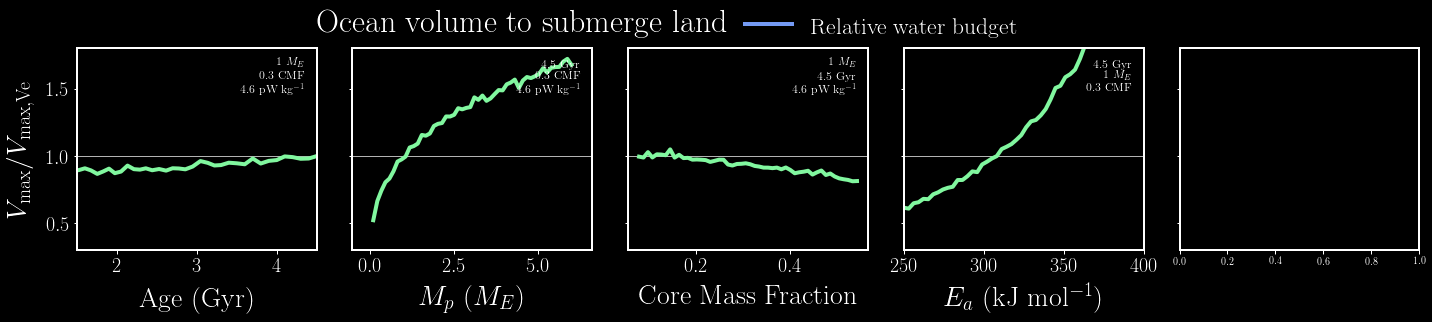

In [2]:
fig, axes = plottop.plot_ocean_capacity_relative(n_stats=100, 
                                                 legsize=23.5, ticksize=20, labelsize=28, wspace=0.15,
                                                 titlesize=32, fig_path=fig_path, save=False,
                                                 defaults='Venusbaseline', 
                                                 title='Ocean volume to submerge land',
                                                 spectrum_fpath=benchmark_path+'wei_Venus/',
                                                 spectrum_fname='model_power_m2_b.csv',
                                                 c='#81f79f', alpha=1, lw=4, ymin=0.3, ymax=1.8, labelpad=10,
                                                 set_ylim=True,
                                                 fname='ocean-vol')

In [15]:
import pyshtools
# import cartopy.crs as ccrs
import pandas as pd
sys.path.insert(0,'/home/claire/Works/exo-top/')
from john_scripts.venus_topo_stats import RMS_from_l_powerspectrum, read_coeffs, plot_Venus 


def hpeak_from_spectrum(power, norm='4pi', lmax=40, n=10, **kwargs):
    ii = 0
    h_peak = []
    while ii < n:
        coeffs_global = pyshtools.SHCoeffs.from_random(power, normalization=norm)
        topo = coeffs_global.expand(lmax=lmax)
        h_peak.append(np.max(topo.data))  # in m
        ii += 1
    return np.mean(h_peak)  # average of a bunch of random spectra consistent with given


def load_spectrum(fpath='', fname='', **kwargs):
#     data = np.genfromtxt(fpath+fname, usecols=(0,1), delimiter=',', dtype=float)
#     # todo : find nearest l for imperfect digitization
#     power = data[:,1]
#     degrees = data[:,0]
    
    df = pd.read_csv(fpath+fname, header=None, names=['l', 'S_l'], index_col=False)

    degrees = df['l']
    power = df['S_l']
    return power, degrees


def scale_spectrum(h_rms, h_rms0=None, phi0=None, pl=None, pl0=None, h_func=None, age=4.5, **kwargs):
    # scale power spectrum phi0 such that it has new rms equal to h_rms

    if h_rms0 is None:
        h_rms0 = powerspectrum_RMS(power_lm=phi0)  # I hope this is a power spectrum, but this probably needs to be multipled by R or something
    ratio = h_rms/h_rms0
    sqrtphi = np.sqrt(phi0) * ratio
    return sqrtphi ** 2


def vol_from_peak(r0, h_peak, vol_ref=1, **kwargs):
    # getting volume in between trough and peak maxima - as troughs fill in peaks, net volume is 0 and total volume is
    # the spherical annulus between r0 and h_peak
    # R_p = 6051.88e3
    EO = 1.35e9 * 1000**3  # e.g. reference volume based on R_E
    vol = 4 / 3 * np.pi * ((r0 + h_peak) ** 3 - r0 ** 3)
    # print('R_p:', r0*1e-3, 'km, h_peak', h_peak*1e-3, 'km, vol:', vol/EO, 'TO')
    return vol / vol_ref


def vol_from_spectrum(phi0=None, fname='', fpath='', r0=1, n_stats=10, **kwargs):
    # volume between min trough and max peak
    d_ocean_Earth = 3.7e3
    if phi0 is None:
        phi0 = load_spectrum(fpath=fpath, fname=fname)
    h_peak0 = hpeak_from_spectrum(phi0, n=n_stats)
    V0 = vol_from_peak(r0, h_peak0)
    return V0


def powerspectrum_RMS(path=None, power_lm=None, degree=None, amplitude=False, lmax=None): # try to calcuate RMS from digitized power spectrum
    if path is not None:
        df = pd.read_csv(path, header=None, names=['degree', 'value'], index_col=False)
        degree= np.array(df['degree'])
        S = np.array(df['value'])
    elif power_lm is not None:
        degree = np.arange(1, len(power_lm)-1)
        S = power_lm

    if lmax is None:
        lmax = degree[-1]

    RMS_l = []
    ii = 0
    l = degree[ii]

    while (l <= lmax) and ii < len(degree):
        Slm = S[ii]
        if amplitude:
            Slm = Slm**2
        RMS_l.append(np.sqrt(Slm/(2*l + 1)))
        ii = ii + 1
        if ii < len(degree):
            l = degree[ii]
        
    RMS = sum(RMS_l)
    print('this RMS', RMS)
    return RMS





this RMS 835.7768334750567


NameError: name 'l' is not defined

this RMS 835.7768334750567


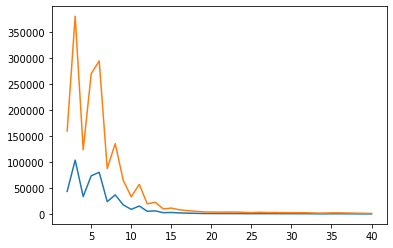

In [17]:
fpath = path+'wei_Venus/'
df = pd.read_csv(fpath+'model_power_m2_b.csv', header=None, names=['l', 'S_l'], index_col=False)

degree = df['l'][1:].to_numpy()
phi0 = df['S_l'][1:].to_numpy()
h_rms0 = powerspectrum_RMS(power_lm=phi0, degree=degree)
RMS_topo_Wei = 892.5386176519198 # m

plt.plot(degree, phi0)

phi1 = scale_spectrum(h_rms=1600, h_rms0=h_rms0, phi0=phi0)

plt.plot(degree, phi1)